# 第五题：实现层次聚类，并与其他聚类算法进行对比（选做）

实验内容：
1. 实现三种形式的层次聚类（最小距离、最大距离、平均距离）
2. 至少选择两个数据集
3. 在这两个数据集上运行自己实现的层次聚类算法和sklearn的KMeans，GMM，DBSCAN，共4个聚类算法
4. 计算外部指标FMI和NMI
5. 绘制4种聚类的聚类效果

## 导入模块

In [25]:
# YOUR CODE HERE
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import normalized_mutual_info_score
from sklearn.metrics import fowlkes_mallows_score

## 导入数据集

In [2]:
from sklearn import datasets
X1, y1 = datasets.make_circles(n_samples = 1500, factor = 0.5, noise = 0.05, random_state = 32)
X2, y2 = datasets.make_moons(n_samples = 1500, noise = 0.05, random_state = 32)

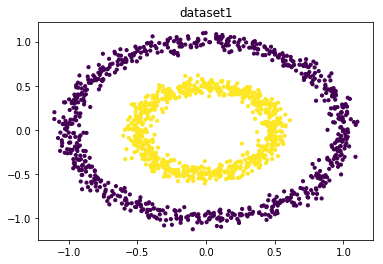

In [3]:
# dataset1
plt.title('dataset1')
plt.scatter(X1[:, 0], X1[:, 1], s = 10, c = y1)

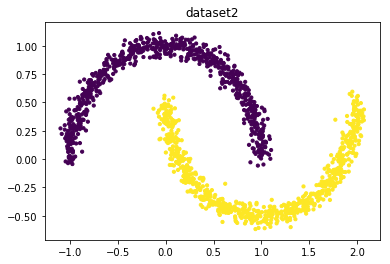

In [4]:
# dataset2
plt.title('dataset2')
plt.scatter(X2[:, 0], X2[:, 1], s = 10, c = y2)

## 使用sklearn训练

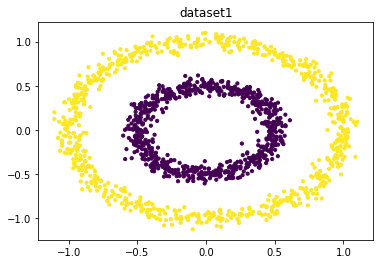

In [5]:
from sklearn.cluster import AgglomerativeClustering

model = AgglomerativeClustering(n_clusters = 2, linkage="single")
model.fit(X1)

pred = model.labels_
plt.title('dataset1')
plt.scatter(X1[:, 0], X1[:, 1], s = 10, c=pred)

## 簇

In [6]:
class Cluster():
    
    def __init__(self, i, l=None, r=None, c=1):
        '''
        id是序号
        left,right是合并的两个字数
        count是簇内点的个数
        '''
        self.id = i
        self.left = l
        self.right = r
        self.count = c
        
    def __eq__(self, other):
        '''
        
        '''
        if other == None:
            return False
        else:
            return self.id == other.id

## 簇的距离对

In [7]:
class ClusterPair():
    def __init__(self, i, j, dis):
        if i > j:
            i, j = j, i
        self.i = i
        self.j = j
        self.dis = dis
        
    def __lt__(self, other):
        
        return self.dis < other.dis

In [8]:
def euler_distance(a, b):
    '''
    计算两点之间的欧拉距离
    '''
    d = np.sqrt(np.square(np.array(a)-np.array(b)).sum())
    return d

In [9]:
a = np.array([1,2])
b = np.array([2,3])
print(euler_distance(a, b))

1.41421356237


In [10]:
import heapq

class distanceMap():
    '''
    self.heap: 用于返回距离最短的两个簇
    self.distanceDict: 记录任意两个簇的距离
    self.clusters: 用于保存所有的簇
    self.wait_to_unit_clusters: 将要合并的簇
    self.clusterid: 每个簇的id号来源
    '''
    
    def __init__(self):
        self.heap = []
        heapq.heapify(self.heap) 
        self.clusters = dict()      
        self.wait_to_unit_clusters = dict()
        self.distanceDict = dict() 
        self.clusterid = None  
    
    def initDistance(self, X):
        '''
            从训练集中初始化簇
        '''
        self.points_num, self.features_num = X.shape
        
        # 向self.clusters中添加簇
        for i in range(self.points_num):
            self.clusters[i] = Cluster(i)
            self.wait_to_unit_clusters[i] = Cluster(i)

        # 保存已有cluster的最大序号
        # 用于建立新簇时往后添加
        self.clusterid = i
        
        # 计算两个簇（点）之间的距离
        for i in range(self.points_num-1):
            for j in range(i+1, self.points_num):
                dis = euler_distance(X[i], X[j])
                
                # 添加到self.heap中
                cp = ClusterPair(i,j, dis)
                heapq.heappush(self.heap, cp)
                # 维护记录任意两个簇距离的字典
                self.distanceDict[(i, j)] = self.distanceDict[(j,i)] = dis
    
    
    def agg(self, linkage):
        
        # 取出最小的，且在self.clusters序号里的
        # 同时这里要注意，取出的pair两个簇未合并过
        mini_cp = None
        while True:
            mini_cp = heapq.heappop(self.heap)
            if mini_cp.i in self.wait_to_unit_clusters and mini_cp.j in self.wait_to_unit_clusters:
                break
        
        # 合并 mini_cp.i 与mini_cp.j
        # 计算新的距离添加到
        self.clusterid += 1
        sum_count = self.clusters[mini_cp.i].count + self.clusters[mini_cp.j].count
        
        # 移除以前的簇
        del self.wait_to_unit_clusters[mini_cp.i]
        del self.wait_to_unit_clusters[mini_cp.j]
        
        # 计算新的距离
        for cl in self.wait_to_unit_clusters:
            
            # 计算新合成的簇和以前簇的距离
            dis = None
            if linkage == 'single':
                dis = (self.distanceDict[(mini_cp.i,cl)] * self.clusters[mini_cp.i].count + 
                       self.distanceDict[(mini_cp.j,cl)] * self.clusters[mini_cp.j].count  ) / sum_count
            elif linkage == 'max':
                dis = max(self.distanceDict[(mini_cp.i, cl)], self.distanceDict[(mini_cp.j, cl)])
            elif linkage == 'min':
                dis = min(self.distanceDict[(mini_cp.i, cl)], self.distanceDict[(mini_cp.j, cl)])
            
            self.distanceDict[(self.clusterid, cl)] = self.distanceDict[(cl, self.clusterid)] = dis

            cp = ClusterPair(cl, self.clusterid, dis)
            heapq.heappush(self.heap, cp)
        
        self.wait_to_unit_clusters[self.clusterid] = self.clusters[self.clusterid] = Cluster(i=self.clusterid, l=mini_cp.i,r=mini_cp.j, c=sum_count)
        
        

In [13]:
class myAgglomerativeClustering():
    def __init__(self, n_cluster=2,linkage='single'):
        self.n_cluster = n_cluster
        self.linkage = linkage
        self.distanceMap = distanceMap()

    def fit(self, X):
        self.distanceMap.initDistance(X)
        
        while len(self.distanceMap.wait_to_unit_clusters) > self.n_cluster:
            self.distanceMap.agg(self.linkage)
        
        y = np.zeros(len(X))
        
        def traverse(i, color):
            t = self.distanceMap.clusters[i]
            if t == None:
                return
            
            # 如果是叶子结点
            if t.left == None and t.right == None:
                y[i] = color
                return
            
            # 如果不是叶子结点
            else:
                traverse(t.left , color)
                traverse(t.right, color)
            
        
        
        color = 0
        for cl in self.distanceMap.wait_to_unit_clusters:
            traverse(cl, color)
            color += 1
        
        self.label = y
        
        
    def predict(self):
        return self.label
    
    

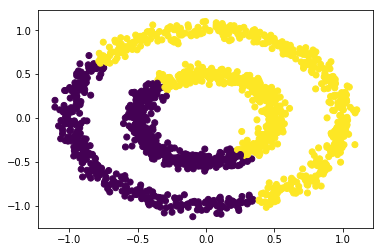

In [14]:
# single
model = myAgglomerativeClustering()
model.fit(X1)
predict = model.predict()
plt.scatter(X1[:, 0], X1[:, 1], c = predict)

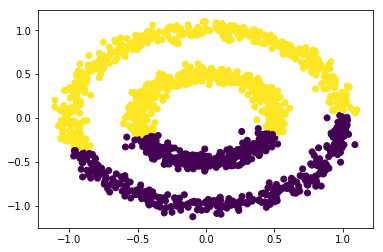

In [15]:
## max
model = myAgglomerativeClustering(linkage='max')
model.fit(X1)
predict = model.predict()
plt.scatter(X1[:, 0], X1[:, 1], c = predict)

1.0 1.0


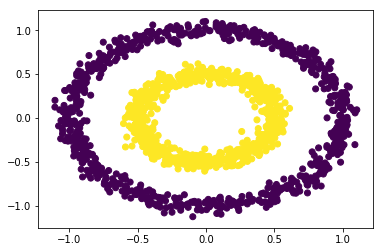

In [38]:
## min
model = myAgglomerativeClustering(linkage='min')
model.fit(X1)
predict = model.predict()
plt.scatter(X1[:, 0], X1[:, 1], c = predict)

n = normalized_mutual_info_score(y1, predict)
f = fowlkes_mallows_score(y1, predict)

print(f, n)

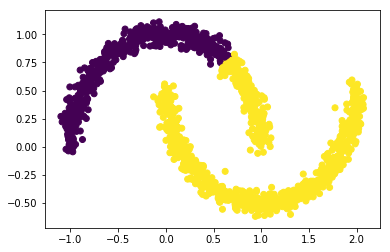

In [17]:
model = myAgglomerativeClustering(linkage='single')
model.fit(X2)
predict = model.predict()
plt.scatter(X2[:, 0], X2[:, 1], c = predict)

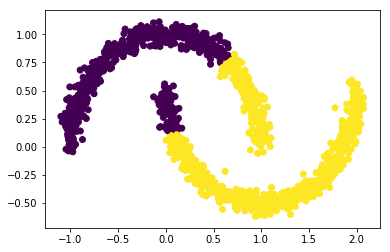

In [18]:
model = myAgglomerativeClustering(linkage='max')
model.fit(X2)
predict = model.predict()
plt.scatter(X2[:, 0], X2[:, 1], c = predict)

1.0 1.0


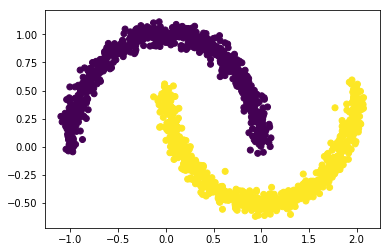

In [37]:
model = myAgglomerativeClustering(linkage='min')
model.fit(X2)
predict = model.predict()
plt.scatter(X2[:, 0], X2[:, 1], c = predict)

n = normalized_mutual_info_score(y2, predict)
f = fowlkes_mallows_score(y2, predict)

print(f, n)

## 后记
在实现这个版本的代码的时候，我遇到predict函数性能的瓶颈
刚开始实现层次聚类时，没有考虑太多性能，直接按照思路瓜书写了代码
发现跑1500个数据样本时，复杂度大的惊人(n^3)，要跑大概10个小时左右才能跑完

我和许多同学讨论了这个性能的问题，很多同学都直接选择了减小样本的个数，样本点采用100个

但是我作为一个固执的ACMer对复杂度就有了很执念的想法
选择了用heap（优先队列）和map(python中的字典)来优化这个复杂度

目前的复杂度是O(n^2 * log(n)) 和sk-learn库是一样  
实测1500个数据样本数，2分钟左右跑完  
有点舒服，哈哈哈哈

## 1. 数据集1(自己实现的层次聚类距离采用最小距离，下同）

聚类算法|FMI|NMI
-|-|-
myAgglomerativeClustering|1|1
kmeans|0.49940016999 | 5.13137579999e-06
GMM|0.499729314488 | 3.21254668591e-05
DSCAN|0.9993331109628394   |0.9963558570293466

## 2. 数据集2

聚类算法|FMI|NMI
-|-|-
myAgglomerativeClustering|1.0|1.0
kmeans|0.624526404259 | 0.188766312522
GMM|0.7474712950600801|0.39518740988341167
DSCAN|0.9986675591186284   |0.9934048122413089

0.49940016999 5.13137579999e-06


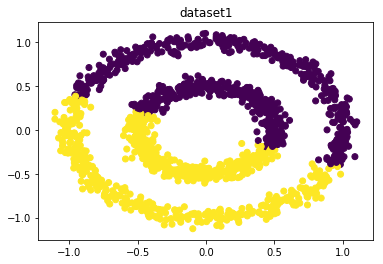

In [29]:
#kmeans
from sklearn.cluster import KMeans

model = KMeans(n_clusters=2)
model.fit(X1)
predict = model.predict(X1)

plt.title('dataset1')
plt.scatter(X1[:, 0], X1[:, 1], c=predict)

n = normalized_mutual_info_score(y1, predict)
f = fowlkes_mallows_score(y1, predict)

print(f, n)

0.499729314488 3.21254668591e-05


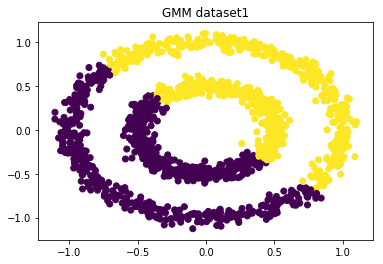

In [32]:
#GMM
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=2)
gmm.fit(X1)

plt.title('GMM dataset1')
plt.scatter(X1[:, 0], X1[:, 1], c =gmm.predict(X1))

n=normalized_mutual_info_score(y1, gmm.predict(X1))
f=fowlkes_mallows_score(y1, gmm.predict(X1))

print(f,n)

0.999333110963 0.996355857029


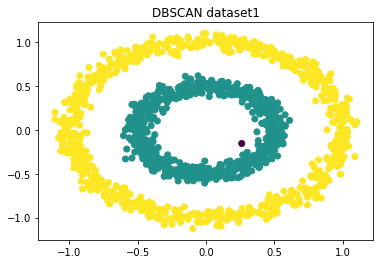

In [35]:
#DBSCAN
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps = 0.1)
dbscan.fit(X1)

plt.title('DBSCAN dataset1')
plt.scatter(X1[:, 0], X1[:, 1],c=dbscan.labels_)

n = normalized_mutual_info_score(y1, dbscan.labels_)
f = fowlkes_mallows_score(y1, dbscan.labels_)
print(f, n)

0.624526404259 0.188766312522


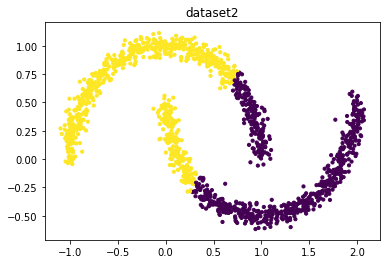

In [41]:
#kmeans
from sklearn.cluster import KMeans

model = KMeans(n_clusters=2)
model.fit(X2)
plt.title('dataset2')
plt.scatter(X2[:, 0], X2[:, 1], s = 10, c=model.predict(X2))
print(fowlkes_mallows_score(y2, model.predict(X2)), normalized_mutual_info_score(y2, model.predict(X2)))

0.395193463998
0.74747219414


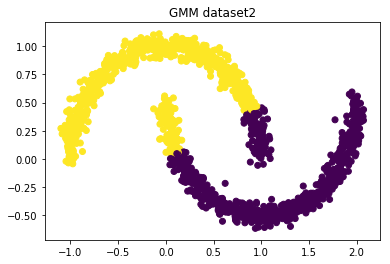

In [42]:
#GMM
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=2)
gmm.fit(X2)

plt.title('GMM dataset2')
plt.scatter(X2[:, 0], X2[:, 1], c = gmm.predict(X2))

print(normalized_mutual_info_score(y2, gmm.predict(X2)))
print(fowlkes_mallows_score(y2, gmm.predict(X2)))

0.993404812241
0.998667559119


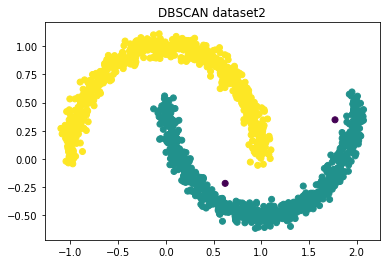

In [43]:
#DBSCAN
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps = 0.1)
dbscan.fit(X2)


plt.title('DBSCAN dataset2')
plt.scatter(X2[:, 0], X2[:, 1], c =dbscan.labels_)

print(normalized_mutual_info_score(y2, dbscan.labels_))
print(fowlkes_mallows_score(y2, dbscan.labels_))